## Poisuelle Flow Using LBM:

In the lattice boltzmann model, one is to solve for the probability distribution function of the "particles". 
I'll be trying to solve the model for a 2D poisuelle flow in a pipe.
The grid used in the problems would be a $D_2Q_9$ type of grid with 9 discretized velocities with different weights.

The calculations on a lattice boltzmann solver are performed in two steps: 1.) the collision 2.) streaming

## Connecting the microscopic quantities to macroscopic:

The probability distribution function of a lattice point is given by $f(\vec{x},\vec{\xi},t)$. Where $\vec{x}$ is the "molecular" position and $\vec{\xi}$ is the microscopic velocity. The microscopic velocity here is discretized in 9 directions for the $D_2Q_9$ cell with weights that normalize the weighted probability density.
The function $f$ gives the "probability" of a particle at a given position and time, with a microscopic velocity would be moving in the direction $\vec{\xi}$ due to kintetic effects.

The dicretized PDF is given by: $f_{\alpha}(\vec{x},t)$
where alpha is the index of the 9 directions it can take in the $D_2Q_9$ cell.

The macroscopic quanities are given by:

Density:
$$ \rho(\vec{x},t) = \sum_{\alpha} f_{\alpha}(\vec{x},t)$$

Momentum per unit volume:

$$ \rho(\vec{x},t)\vec{u}(\vec{x},t) = \sum_{\alpha} f_{\alpha}(\vec{x},t)\vec{c}_{\alpha}$$

Here, $\vec{c}_{\alpha} $ is the discrete velocity vector set

Pressure for a lattice point can be calculated using: $P = \rho c_s^2 $

## The Lattice Boltzman Equation:

The lattice boltzmann equation is given by:

$$f_{\alpha}(\vec{x}+\vec{c}_{\alpha}\Delta t,t+\Delta t) - f_{\alpha}(\vec{x},t) = -\frac{(f_{\alpha}(\vec{x},t))- f_{\alpha}^{eq}(\vec{x},t)}{\tau/\Delta t}$$

Here, the $f_{\alpha}^{eq}(\vec{x},t)$ comes from the maxwell boltzmann distribution, which is given by:
$$ f_{\alpha}^{eq}(\vec{x},t) = w_\alpha \rho \left(1+ \frac{\vec{u}\cdot \vec{c}_\alpha}{c_s^2}+\frac{(\vec{u}\cdot \vec{c}_\alpha)^2}{2c_s^4}-\frac{\vec{u}\cdot \vec{u}}{2c_s^2}\right)$$

Here:
\
\begin{align*}
\rho & \rightarrow \text{macroscopic density} (\vec{x},t) \\
\vec{u} & \rightarrow \text{macroscopic velocity} (\vec{x},t)\\
w_\alpha & \rightarrow \text{weights given to microscopic velocity} (\vec{x},t)\\
c_\alpha & \rightarrow \text{discrete velocity} (\vec{x},t)\\
c_s & \rightarrow \text{speed of sound} (\vec{x},t)
\ \text{where: } c_s^2 = \frac{1}{3}\left(\frac{\Delta x}{\Delta t}\right)^2
\end{align*}
\

The pressure is now directly related to density as $P = \rho c_s^2$

The $f_{\alpha}^{eq}(\vec{x},t)$ satisfies the normal PDF conditions:
$$ \sum_\alpha f_{\alpha}^{eq}(\vec{x},t) = \rho(\vec{x},t) $$
and 
$$ \sum_\alpha f_{\alpha}^{eq}(\vec{x},t)\;\vec{c}_\alpha = \rho\;\vec{u}(\vec{x},t) $$


## Steps for Solving:

### 1.) Collision:

$$ f_{\alpha}^\star(\vec{x},t) = f_{\alpha}(\vec{x},t) - \frac{\Delta t}{\tau}\left(f_{\alpha}(\vec{x},t)-f_{\alpha}^{eq}(\vec{x},t)\right)$$

The collision equation is modified in the presence of an external force.
( See section "Gno's forcing Scheme for reference)

### 2.) Streaming:

$$ f_{\alpha}(\vec{x}+\vec{c}_{\alpha}\Delta t,t+\Delta t) = f_{\alpha}^\star(\vec{x},t) $$

This is the step where you basically assign the distribution function to the subsequent cell.

### Overall Implementation:

The implementation of a model is done in the following manner:

1.) Initialize the distribution function $f$:
$$ f_\alpha = f_\alpha^{eq}\left(\rho(x,0),u(x,0)\right) $$

2.) Start the time loop:
$$ t = t+\Delta t $$

3.) Compute the density $\rho$ and velocity $\vec u $ using the macroscopic formula for density and moment.

4.) Use the new density and velocity to update the $f_\alpha^{eq}$

5.) Apply the collision step and the streaming step to update $f$

6.) Apply boundary conditions

7.) Loop it over time!

## Implementation of Poisuelle Flow using LBM:

In [1]:
import numpy as np

In [2]:
# initialize the problem:
#note: I define the domain by the dimension of wet nodes. the dry nodes are then padded onto the wet domain
nx = 5
ny = 3
deltat = 1
tau = 0.8
rho = 1.0
dpdx = 1.0e-5
u = np.zeros([nx,ny,2]) #initialized velocity vector over the region of calculation
cssquare = 1/3

# velocity weights for the D2Q9 grid
w = [4/9,1/9,1/9,1/9,1/9,1/36,1/36,1/36,1/36]
# velocity vectors "c"
c = np.array([[0,0],[1, 0],[0, 1],[-1, 0],[0, -1],[1, 1],[-1, 1],[-1, -1],[1, -1]])

#problem space
S = np.zeros((nx,ny))

In [1]:
# functions for different operations:
'''
function 1: calculates the value of f_alpha^eq for each node and stores them in a numpy array of 9 element each containing the 
value of f at all alpha directions! It takes in the values of macroscopic velocity vector u (a 2*2 array) for that node and the
macroscopic density at the node as input.
'''

def calc_feq(u, rho):
    global w
    global c
    global cssquare
    cs2 = cssquare
    feq = np.zeros(9)
    for i in range(len(feq)):
        term1 = np.dot(u,c[i])/cs2
        term2 = (term1**2)/2
        term3 = np.dot(u,u)/(2*cs2)
        feq[i] = w[i]*rho*(1+term1+term2-term3)
    return feq

'''
function 2: calculates the macroscopic density at any given node using the disribution function f_alpha for the node.
'''

def calc_density(f):
    rho = np.sum(f)
    return rho

'''
function 3: calculates the macroscopic momenta at any given node using the disribution function f_alpha and c_alpha for the node.
'''

def calc_moment(f):
    moment = [0,0]
    global c
    for i in range(len(f)):
        moment += f[i]*c[i]
    return moment

## Guo's Forcing Scheme

While the Lattice Boltzmann Equation written above is valid, I still have to accomodate for the forces applied due to a pressure difference . The force updated LBE is given by:

If $\matrix{F}$ is body force in the fluid, then:
$$f_{\alpha}(\vec{x}+\vec{c}_{\alpha}\Delta t,t+\Delta t) - f_{\alpha}(\vec{x},t) = -\frac{(f_{\alpha}(\vec{x},t))- f_{\alpha}^{eq}(\vec{x},t)}{\tau/\Delta t}+ \Delta t F_i$$

here, the Equilibrium Distribution functions $f_\alpha^{eq}$ is given by:
$$ f_\alpha^{eq} = E_\alpha(\rho, \vec u^\star) \; \text{with}\; \rho \vec u^\star = \sum_\alpha c_\alpha f_\alpha + F\frac{\Delta t}{2} $$

The shear viscosity of the fluid is given by: $$ \nu=\left(\tau-\frac{1}{2}\right)c_s^2\Delta t$$

The collision operator is shited in the following manner:

$$ f_\alpha^* = f_\alpha +(\Omega_\alpha + S_\alpha)\Delta t $$
$$ \Omega_\alpha = -\frac{(f_\alpha - f_\alpha^{eq})}{\tau} \text{...BGK Operator}$$
$$ S_\alpha = \left(1-\frac{\Delta t}{2\tau}\right)w_\alpha \left(\frac{\vec{c_\alpha} -\vec u}{c_s^2}+\frac{(\vec{c_\alpha}.\vec u)\vec {c_\alpha}}{c_s^4}\right).\vec{F}$$

## A case for poiseuille's flow:

For the case of poiseuille flow, a quantity $\frac{dp}{dx}$ may be given to be a constant. In such a case the body force F, only acts along the x axis. Which means:
$$ \matrix F = \frac{dp}{dx}\hat{i} + 0 \hat{j}$$

For the forcing scheme:
$$\rho \vec u^\star = \sum_\alpha c_\alpha f_\alpha + F\frac{\Delta t}{2} $$

The term $ \sum_\alpha c_\alpha f_\alpha $ is just the macroscopic velocity set up initially, which is infact equal to 0.
Therefore, we have:
$$ \rho \vec{u}^\star = \frac{1}{2}\frac{dp}{dx}\hat{i} $$

And $$ u_x = \frac{1}{2\rho}\frac{dp}{dx}$$

Note: Since this is used in the calculation of moment, the same velocity addition/ correction term should be added to the x velocity calculated before the collision step (beginning of the new loop) for every time step.

## Boundary Conditions for LBM Models:

### Periodic Boundary Condition:

The periodice boundary condition entails:
$$ f_{in}(i=0,j) = f_{out}(i=Nx, j)$$

The outer bound (East facing)disrete velocities have the index 1,5 and 8.
These outer bound discrete velocities are streamed to the first node in the west for applying the periodic boundary conditions.

The inbound discrete (West Facing) velocities have the index 3,6 and 7.
These indbound veloicities are streamed to the last node in the east for applying the periodic boundary conditions.
    Syntax:$$ 
            ia = i+Cxa \\
            ja = j+Cya \\
            if (ia > Nx):\\
                ia =1\\
            if (ia < 1):\\
                ia = Nx\\
        $$

### Bounceback Boundary Condition:

The existance of a wall is resolved by the use of half-way bounceback boundary condition.
$$ f_\alpha (x_f, t+\Delta t) =f_{\alpha '}^* (x_f, t+\Delta t) $$

The $\alpha '$ is the opposite direction of the original $\alpha$ direction.
So, for direction 4,7 and 8, the complementary directions are 2,5 and 6 respectively.


In [50]:
# initialize f_alpha as a 3D array containing the space details in the first 2 indices and the last index being the alpha value
f = np.zeros([nx,ny,9]) #note: the +2 is for the dry nodes, even though the dry nodes don't have an actual distribution,
                        # they may be temporarily given on to be alloted after bounceback

for i in range(nx):
    for j in range(ny):
        f[i][j] = calc_feq(u[i][j], rho) #note: vec{u} = 0 for all positions in the beginning


In [6]:
#calculate the density velocity and feq using gno's forcing scheme
#initialize density as 
rho_array = np.zeros([nx,ny]) # this will give you density as rho(x,y)


for i in range(nx):
    for j in range(ny):
        rho_array[i][j] = calc_density(f[i][j][:])
        u[i][j][:] = calc_moment(f[i][j][:]) # calculate velocity (without force correction)
        u[i][j][0] = u[i][j][0]+dpdx/2 # adding the forcing scheme to change x component velocity
        u[i][j][:] = u[i][j][:]/rho_array[i][j] #calculates the velocity vector for each position
        
        #now we calculate the feq again using the updated velocity and density
        feq = np.zeros([nx,ny,9])
        feq[i][j] = calc_feq(u[i][j], rho_array[i][j])
        
        # calculating the source term for forcing
        source = np.zeros([nx,ny,9])
        for a in range(9):
            source[i][j][a] = (1-0.5/tau)*w[a]*(3*(c[a][0]-u[i][j][0])+9*(c[a][0]*u[i][j][0]+c[a][1]*u[i][j][1])*c[a][0])*dpdx
            #should be converted to a function later on
        #perform the collision step and store the value of f in temporary variable:
        for a in range(9):
            ft = np.zeros([nx,ny,9])
            ft[i][j][a] = f[i][j][a] - (f[i][j][a]-feq[i][j][a])/tau + source[i][j][a]
            
        # note that the collision step is performed only in for the wet nodes of the domain i.e part of the s matrix where the 
        #value of s[i,j] is 0

In [64]:
for i in range(nx):
    for j in range(1,ny-1):
            for a in range(9):
                ia = i+c[a][0]*deltat
                ja = j+c[a][1]*deltat
                # incorporating periodic boundary condition
                if ia>nx-1:
                    ia = 0
                if ia<0:
                    ia = nx-1
                f[ia][ja][a]= ft[i][j][a]
#the above loop takes care of all fluid nodes not a part of the boundary! the fluid nodes at j= 0 and j = ny-1 are yet to be streamed

# now, I manually stream the velocities in the border points
for i in range(nx):
    #streaming horizontal velocities
    i1 = i+c[1][0]*deltat
    i3 = i+c[3][0]*deltat
    if i1>nx-1:
        i1 = 0
    if i3<0:
        i3= nx-1
    f[i1][0][1] = ft[i][0][1] # stream velocity '1' in forward direction for bottom row
    f[i1][ny-1][1] = ft[i][ny-1][1] # stream velocity '1' in forward direction for top row
    f[i3][0][3] = ft[i][0][3] # stream velocity '3' in the backward direction for bottow row
    f[i3][ny-1][3] = ft[i][ny-1][3] # stream velocity '3' in the backward direction for top row
    f[i][0][2] = f[i][0][4] #bounceback on direction '4'
    f[i][0][5] = f[i][0][7] #bounceback on direction '7'
    f[i][0][6] = f[i][0][8] #bounceback on direction '8'
    f[i][ny-1][2] = f[i][ny-1][4] 
    f[i][ny-1][5] = f[i][ny-1][7] 
    f[i][ny-1][6] = f[i][ny-1][8]

# and this should end my time loop, this was my shittiest way of incorporating boundary bounce back

In [2]:
## lets combine all these steps into a time loop!

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

nx = 201
ny = 21
deltat = 1
tau = 0.8 # determined by the kinematic viscosity formula
rho = 1.0
dpdx = 1.0e-5
u = np.zeros([nx,ny,2])
cssquare = 1/3
iterationtime =200

# velocity weights for the D2Q9 grid
w = [4/9,1/9,1/9,1/9,1/9,1/36,1/36,1/36,1/36]
# velocity vectors "c"
c = np.array([[0,0],[1, 0],[0, 1],[-1, 0],[0, -1],[1, 1],[-1, 1],[-1, -1],[1, -1]])

f = np.zeros([nx,ny,9])
for i in range(nx):
    for j in range(ny):
        f[i][j] = calc_feq(u[i][j], rho)
        
rho_array = np.zeros([nx,ny])
feq = np.zeros([nx,ny,9])
source = np.zeros([nx,ny,9])
ft = np.zeros([nx,ny,9])
# initialize some of the parameters to be used within the loop

for t in tqdm(range(iterationtime)):
    for i in range(nx):
        for j in range(ny):
            rho_array[i][j] = calc_density(f[i][j][:])
            u[i][j][:] = calc_moment(f[i][j][:])
            u[i][j][0] = u[i][j][0]+dpdx/2
            u[i][j][:] = (u[i][j][:])/(rho_array[i][j])

            feq[i][j] = calc_feq(u[i][j], rho_array[i][j])

            for a in range(9):
                source[i][j][a] = (1-0.5/tau)*w[a]*(3*(c[a][0]-u[i][j][0])+9*(c[a][0]*u[i][j][0]+c[a][1]*u[i][j][1])*c[a][0])*dpdx
            for a in range(9):
                ft[i][j][a] = f[i][j][a] - (f[i][j][a]-feq[i][j][a])/tau + source[i][j][a]
    #collision step ends by saving the post collision distributions in ft

    #streaming begins here
    for i in range(nx):
        for j in range(1,ny-1):
                for a in range(9):
                    ia = i+c[a][0]*deltat
                    ja = j+c[a][1]*deltat
                    # incorporating periodic boundary condition
                    if ia>nx-1:
                        ia = 0
                    if ia<0:
                        ia = nx-1
                    f[ia][ja][a]= ft[i][j][a]
    # accomodating border rows
    for i in range(nx):
        #streaming horizontal velocities
        i1 = i+c[1][0]*deltat #ideally i+1
        i3 = i+c[3][0]*deltat #ideally i-1
        if i1>nx-1:
            i1 = 0
        if i3<0:
            i3= nx-1
        f[i1][0][1] = ft[i][0][1] # stream velocity '1' in forward direction for bottom row
        f[i1][ny-1][1] = ft[i][ny-1][1] # stream velocity '1' in forward direction for top row
        f[i3][0][3] = ft[i][0][3] # stream velocity '3' in the backward direction for bottow row
        f[i3][ny-1][3] = ft[i][ny-1][3] # stream velocity '3' in the backward direction for top row
        f[i][0][2] = ft[i][0][4] #bounceback on direction '4'
        f[i][0][5] = ft[i][0][7] #bounceback on direction '7'
        f[i][0][6] = ft[i][0][8] #bounceback on direction '8'
        f[i][ny-1][4] = ft[i][ny-1][2] 
        f[i][ny-1][7] = ft[i][ny-1][5] 
        f[i][ny-1][8] = ft[i][ny-1][6]
        # time loop ends here and forms the new distribution function matrix f


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [01:54<00:00,  1.75it/s]


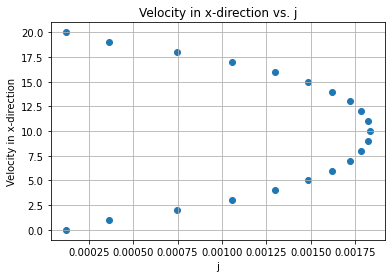

In [3]:
import numpy as np
import matplotlib.pyplot as plt

velocities = []

for j in range(ny):
    velocities.append(u[100][j][0])

plt.scatter(velocities, range(ny))
plt.xlabel('j')
plt.ylabel('Velocity in x-direction')
plt.title('Velocity in x-direction vs. j')
plt.grid(True)
plt.show()


In [ ]:
#that's everything!